In [1]:
import tensorflow as ts
import pandas as pd
import numpy as np
import os

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
data.iloc[0]['comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
x = data['comment_text']
y = data[data.columns[2:]].values

In [7]:
max_features = 200000

In [8]:
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=1800, output_mode='int')

In [9]:
vectorizer.adapt(x.values)

In [10]:
vectorizer("Hello friend, how are you?")[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([288, 897,  73,  20,   7], dtype=int64)>

In [11]:
vectorized_text = vectorizer(x.values)

In [12]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [13]:
dataset = ts.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [14]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [15]:
batch_y.shape

(16, 6)

In [16]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [17]:
train_generator = train.as_numpy_iterator()

In [18]:
train_generator.next()

(array([[    8,    19,   183, ...,     0,     0,     0],
        [28864, 16503,     2, ...,     0,     0,     0],
        [34825, 34825,     9, ...,     0,     0,     0],
        ...,
        [   66,     9,    29, ...,     0,     0,     0],
        [ 1610,     4, 41662, ...,     0,     0,     0],
        [   33,     7,    69, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [23]:
model = Sequential()
model.add(Embedding(max_features+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [24]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [26]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 5708s 816ms/step - loss: 0.0631 - val_loss: 0.0461


In [27]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

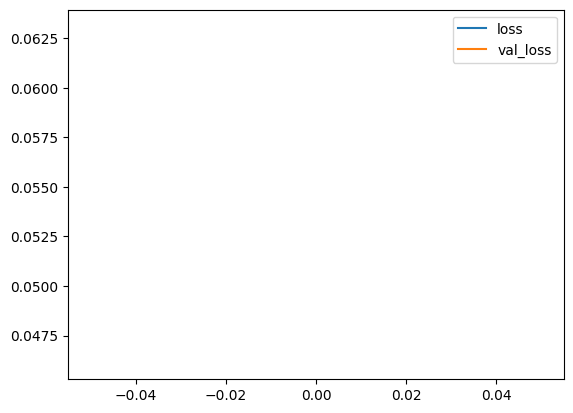

In [28]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [33]:
text = vectorizer("you freaking suck! I am going to hurt you")

In [34]:
text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7158,  397, ...,    0,    0,    0], dtype=int64)>

In [35]:
batch = test.as_numpy_iterator().next()

In [37]:
model.predict(np.expand_dims(text, 0))

1/1 [==============================] - 0s 157ms/step


array([[0.9959344 , 0.38851434, 0.9739785 , 0.03690104, 0.89411503,
        0.12137173]], dtype=float32)

In [38]:
data.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')